# OPERA Displacment from Sentinel-1 Products: Steaming access

This notebook introduces basic tools for searching and accessing [Observational Products for End-Users from Remote Sensing Analysis](https://www.jpl.nasa.gov/go/opera/)(OPERA) Displacement from Sentinel-1 (DISP-S1) products, available through the ASF DAAC.



## Searching using `opera-utils`

There are several ways to find interesting OPERA DISP data.

### Finding data on the ASF portal

One way is through to click around on the Displacemnt portal, https://displacement.asf.alaska.edu/ . This is a fun way to explore a huge amount of data all over the continent. 
A large caveat is that the portal shows the "short wavelegnth displacement" layer, a filtered version of the full InSAR results. From the portal:

> The short wavelength displacement layer is filtered to highlight local displacement (< 30 km wavelength) and remove long wavelength signals such as atmospheric noise. See the [FAQ](https://docs.asf.alaska.edu/datasets/disp_faq) and the [OPERA DISP Product Specification Document](https://www.jpl.nasa.gov/go/opera/products/disp-product-suite/) 


Full documentation by ASF: https://docs.asf.alaska.edu/vertex/displacement/#displacement-portal


### Using data on the ASF portal

You can use the normal https://search.asf.alaska.edu/ page to find OPERA data: https://search.asf.alaska.edu/#/?maxResults=250&dataset=OPERA-S1&productTypes=DISP-S1

The downsides here are 1) you can't click and see a time series, 2) the temporal filters are somewhat broken currently (due to a CMR filtering limitation).

### Using `opera-utils`

The [`opera-utils` library](https://github.com/opera-adt/opera-utils) has a number of functions for searching, parsing, streaming, and downloading OPERA data.

Here, we will use it to demonstrate the ability to easily stream data via the S3 direct access mechanism of ASF. This will *only* work on machines that are "in-region" EC2 instances (like OpenSARLab).

In [1]:
from datetime import datetime
from opera_utils import disp

%load_ext rich

In [2]:
bbox = -117.85, 35.4, -117.2, 36

results = disp.search(
    frame_id=18903,
    start_datetime=datetime(2019, 7, 3),
    end_datetime=datetime(2019, 7, 17),
    url_type="s3",
    print_urls=True,
)

s3://asf-cumulus-prod-opera-products/OPERA_L3_DISP-S1_V1/OPERA_L3_DISP-S1_IW_F18903_VV_20190517T135200Z_20190704T135202Z_v1.0_20250619T061148Z/OPERA_L3_DISP-S1_IW_F18903_VV_20190517T135200Z_20190704T135202Z_v1.0_20250619T061148Z.nc
s3://asf-cumulus-prod-opera-products/OPERA_L3_DISP-S1_V1/OPERA_L3_DISP-S1_IW_F18903_VV_20190517T135200Z_20190716T135203Z_v1.0_20250619T061148Z/OPERA_L3_DISP-S1_IW_F18903_VV_20190517T135200Z_20190716T135203Z_v1.0_20250619T061148Z.nc


In [3]:
results[0]


DispProduct(
    filename='s3://asf-cumulus-prod-opera-products/OPERA_L3_DISP-S1_V1/OPERA_L3_DISP-S1_IW_F18903_VV_20190517T135200Z_20190704T135202Z_v1.0_20250619T061148Z/OPERA_L3_DISP-S1_IW_F18903_VV_20190517T135200Z_20190704T135202Z_v1.0_20250619T061148Z.nc',
    sensor='S1',
    acquisition_mode='IW',
    frame_id=18903,
    polarization='VV',
    reference_datetime=datetime.datetime(2019, 5, 17, 13, 52, tzinfo=datetime.timezone.utc),
    secondary_datetime=datetime.datetime(2019, 7, 4, 13, 52, 2, tzinfo=datetime.timezone.utc),
    version='1.0',
    generation_datetime=datetime.datetime(2025, 6, 19, 6, 11, 48, tzinfo=datetime.timezone.utc),
    size_in_bytes=385875968
)

In [4]:
import matplotlib.pyplot as plt
import ultraplot as uplt

# import h5py # Also possible to use h5py to open and stream! see the `disp.open_h5` function for more
import xarray as xr

%matplotlib inline

In [5]:
%%time
ds_reference = xr.open_dataset(disp.open_file(results[0]))
ds_reference

CPU times: user 583 ms, sys: 78.6 ms, total: 662 ms
Wall time: 3.79 s


<xarray.Dataset> Size: 3GB
Dimensions:                         (time: 1, y: 7061, x: 9721)
Coordinates:
  * y                               (y) float64 56kB 4.004e+06 ... 3.792e+06
  * x                               (x) float64 78kB 3.085e+05 ... 6.001e+05
  * time                            (time) datetime64[ns] 8B 2019-07-04T13:52...
Data variables: (12/13)
    spatial_ref                     int64 8B ...
    reference_time                  (time) datetime64[ns] 8B ...
    displacement                    (y, x) float32 275MB ...
    short_wavelength_displacement   (y, x) float32 275MB ...
    recommended_mask                (y, x) float32 275MB ...
    connected_component_labels      (y, x) float32 275MB ...
    ...                              ...
    estimated_phase_quality         (y, x) float32 275MB ...
    persistent_scatterer_mask       (y, x) float32 275MB ...
    shp_counts                      (y, x) float32 275MB ...
    water_mask                      (y, x) float32 275MB ...
    phase_similarity                (y, x) float32 275MB ...
    timeseries_inversion_residuals  (y, x) float32 275MB ...
Attributes:
    Conventions:         CF-1.8
    contact:             opera-sds-ops@jpl.nasa.gov
    institution:         NASA JPL
    mission_name:        OPERA
    reference_document:  JPL D-108765
    title:               OPERA_L3_DISP-S1 Product

In [6]:
print("All available variables:")
print(list(ds_reference.data_vars))

All available variables:
['spatial_ref', 'reference_time', 'displacement', 'short_wavelength_displacement', 'recommended_mask', 'connected_component_labels', 'temporal_coherence', 'estimated_phase_quality', 'persistent_scatterer_mask', 'shp_counts', 'water_mask', 'phase_similarity', 'timeseries_inversion_residuals']


In [7]:
%%time
ds_secondary = xr.open_dataset(disp.open_file(results[1]))
difference = ds_secondary.displacement - ds_reference.displacement
difference

CPU times: user 3.25 s, sys: 251 ms, total: 3.5 s
Wall time: 21.7 s


<xarray.DataArray 'displacement' (y: 7061, x: 9721)> Size: 275MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(7061, 9721), dtype=float32)
Coordinates:
  * y        (y) float64 56kB 4.004e+06 4.004e+06 ... 3.792e+06 3.792e+06
  * x        (x) float64 78kB 3.085e+05 3.085e+05 3.085e+05 ... 6e+05 6.001e+05

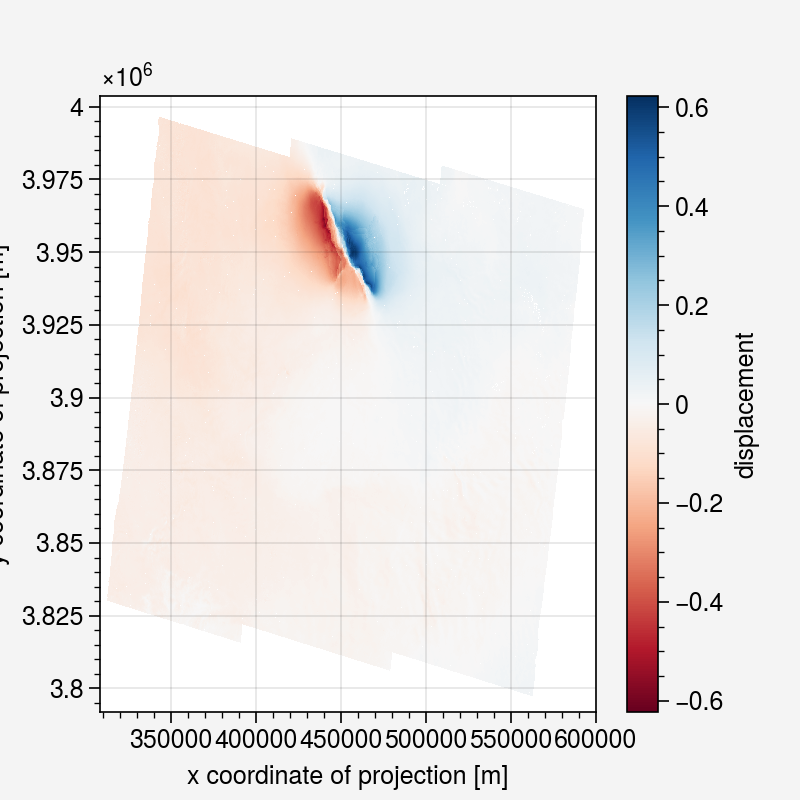

In [8]:
plt.figure()
difference.plot.imshow(cmap="RdBu")

## Subsetting a lat/lon box

In [9]:
product = results[0]
lon_left, lat_bottom, lon_right, lat_top = bbox
row_start, col_start = product.lonlat_to_rowcol(lon_left, lat_top)
row_stop, col_stop = product.lonlat_to_rowcol(lon_right, lat_bottom)
rows = slice(row_start, row_stop)
cols = slice(col_start, col_stop)
print(rows, cols)

slice(648, 2876, None) slice(3831, 5779, None)


In [15]:
ref_sub = ds_reference.isel(y=rows, x=cols)
sec_sub = ds_secondary.isel(y=rows, x=cols)

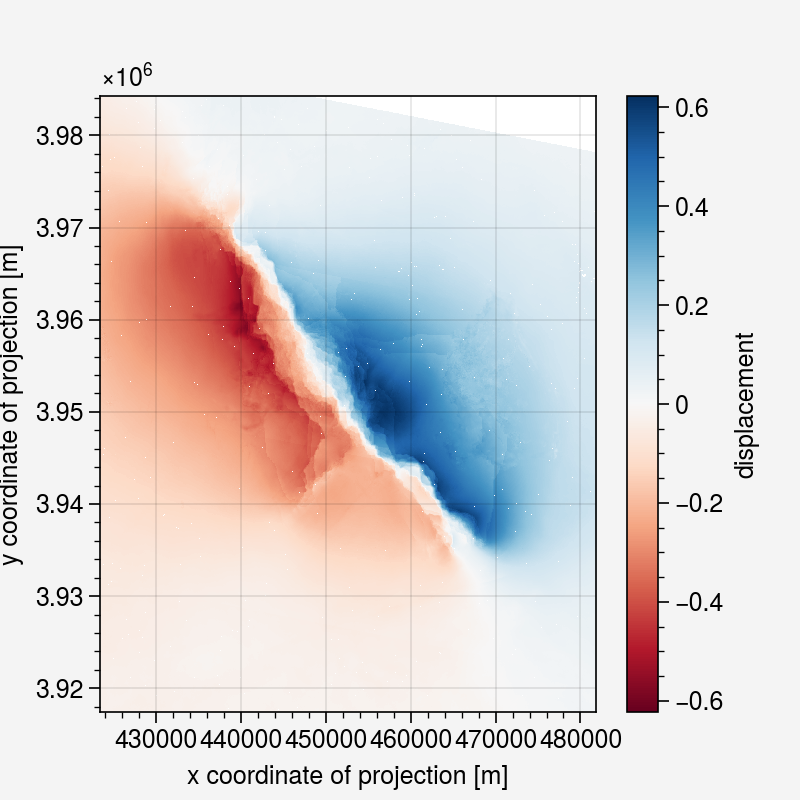

In [14]:
difference_sub = sec_sub.displacement - ref_sub.displacement
difference_sub.plot.imshow(cmap="RdBu")

## Masking using the quality metrics

OPERA DISP-S1 products have multiple layers to indicate the "quality" of the output:
1. Temporal coherence - quality of the phase linking optimization. Essentially this says, on a scale from 0 to 1, how well all the interferograms that were formed agree with each other (This is *not* the same as "MintPy's 'temporal_coherence')
2. Phase similarity - The median cosine similarity of the (nearest-3 network of) interferograms that were unwrapped. Ranges from -1 (where the pixel is 180 degrees out of sync with all of its neighbors) to +1 (all pixels in the neighborhood agree).
3. "Estimated phase quality" - A moving window correlation metric  (from 0 to 1) taken for each interferogram separately. Qualitatively blurrier due to the moving average.
4. Time series inversion residuals - after unwrapping, the time series at each pixel is used to reform the unwrapped differences, which are compared comapred with the original unwrapped interferograms. Similar to the mintpy residuals, except for most pixels, it will be either 0, or a multiple of 2$\pi$.


For this area, most quality metrics are quite high (the desert stays coherent), but the large rupture leads to unwrapping errors.
We can combine both of these metrics, picking only high-coherence pixels which show either 0 or an exact multiple of 2-pi for the time series residuals

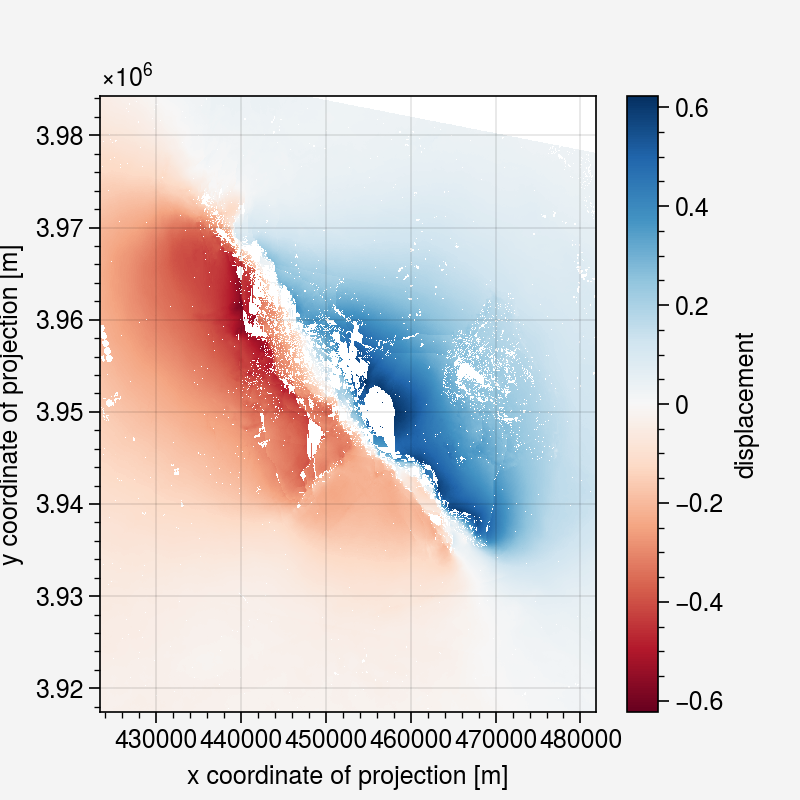

In [16]:
plt.figure()
unlikely_unwrap_errors = (sec_sub.timeseries_inversion_residuals % 6.28) < 0.01
high_coherence = sec_sub.temporal_coherence > 0.7
difference_sub.where(high_coherence * unlikely_unwrap_errors).plot.imshow(cmap="RdBu");

## Demo of all available layers

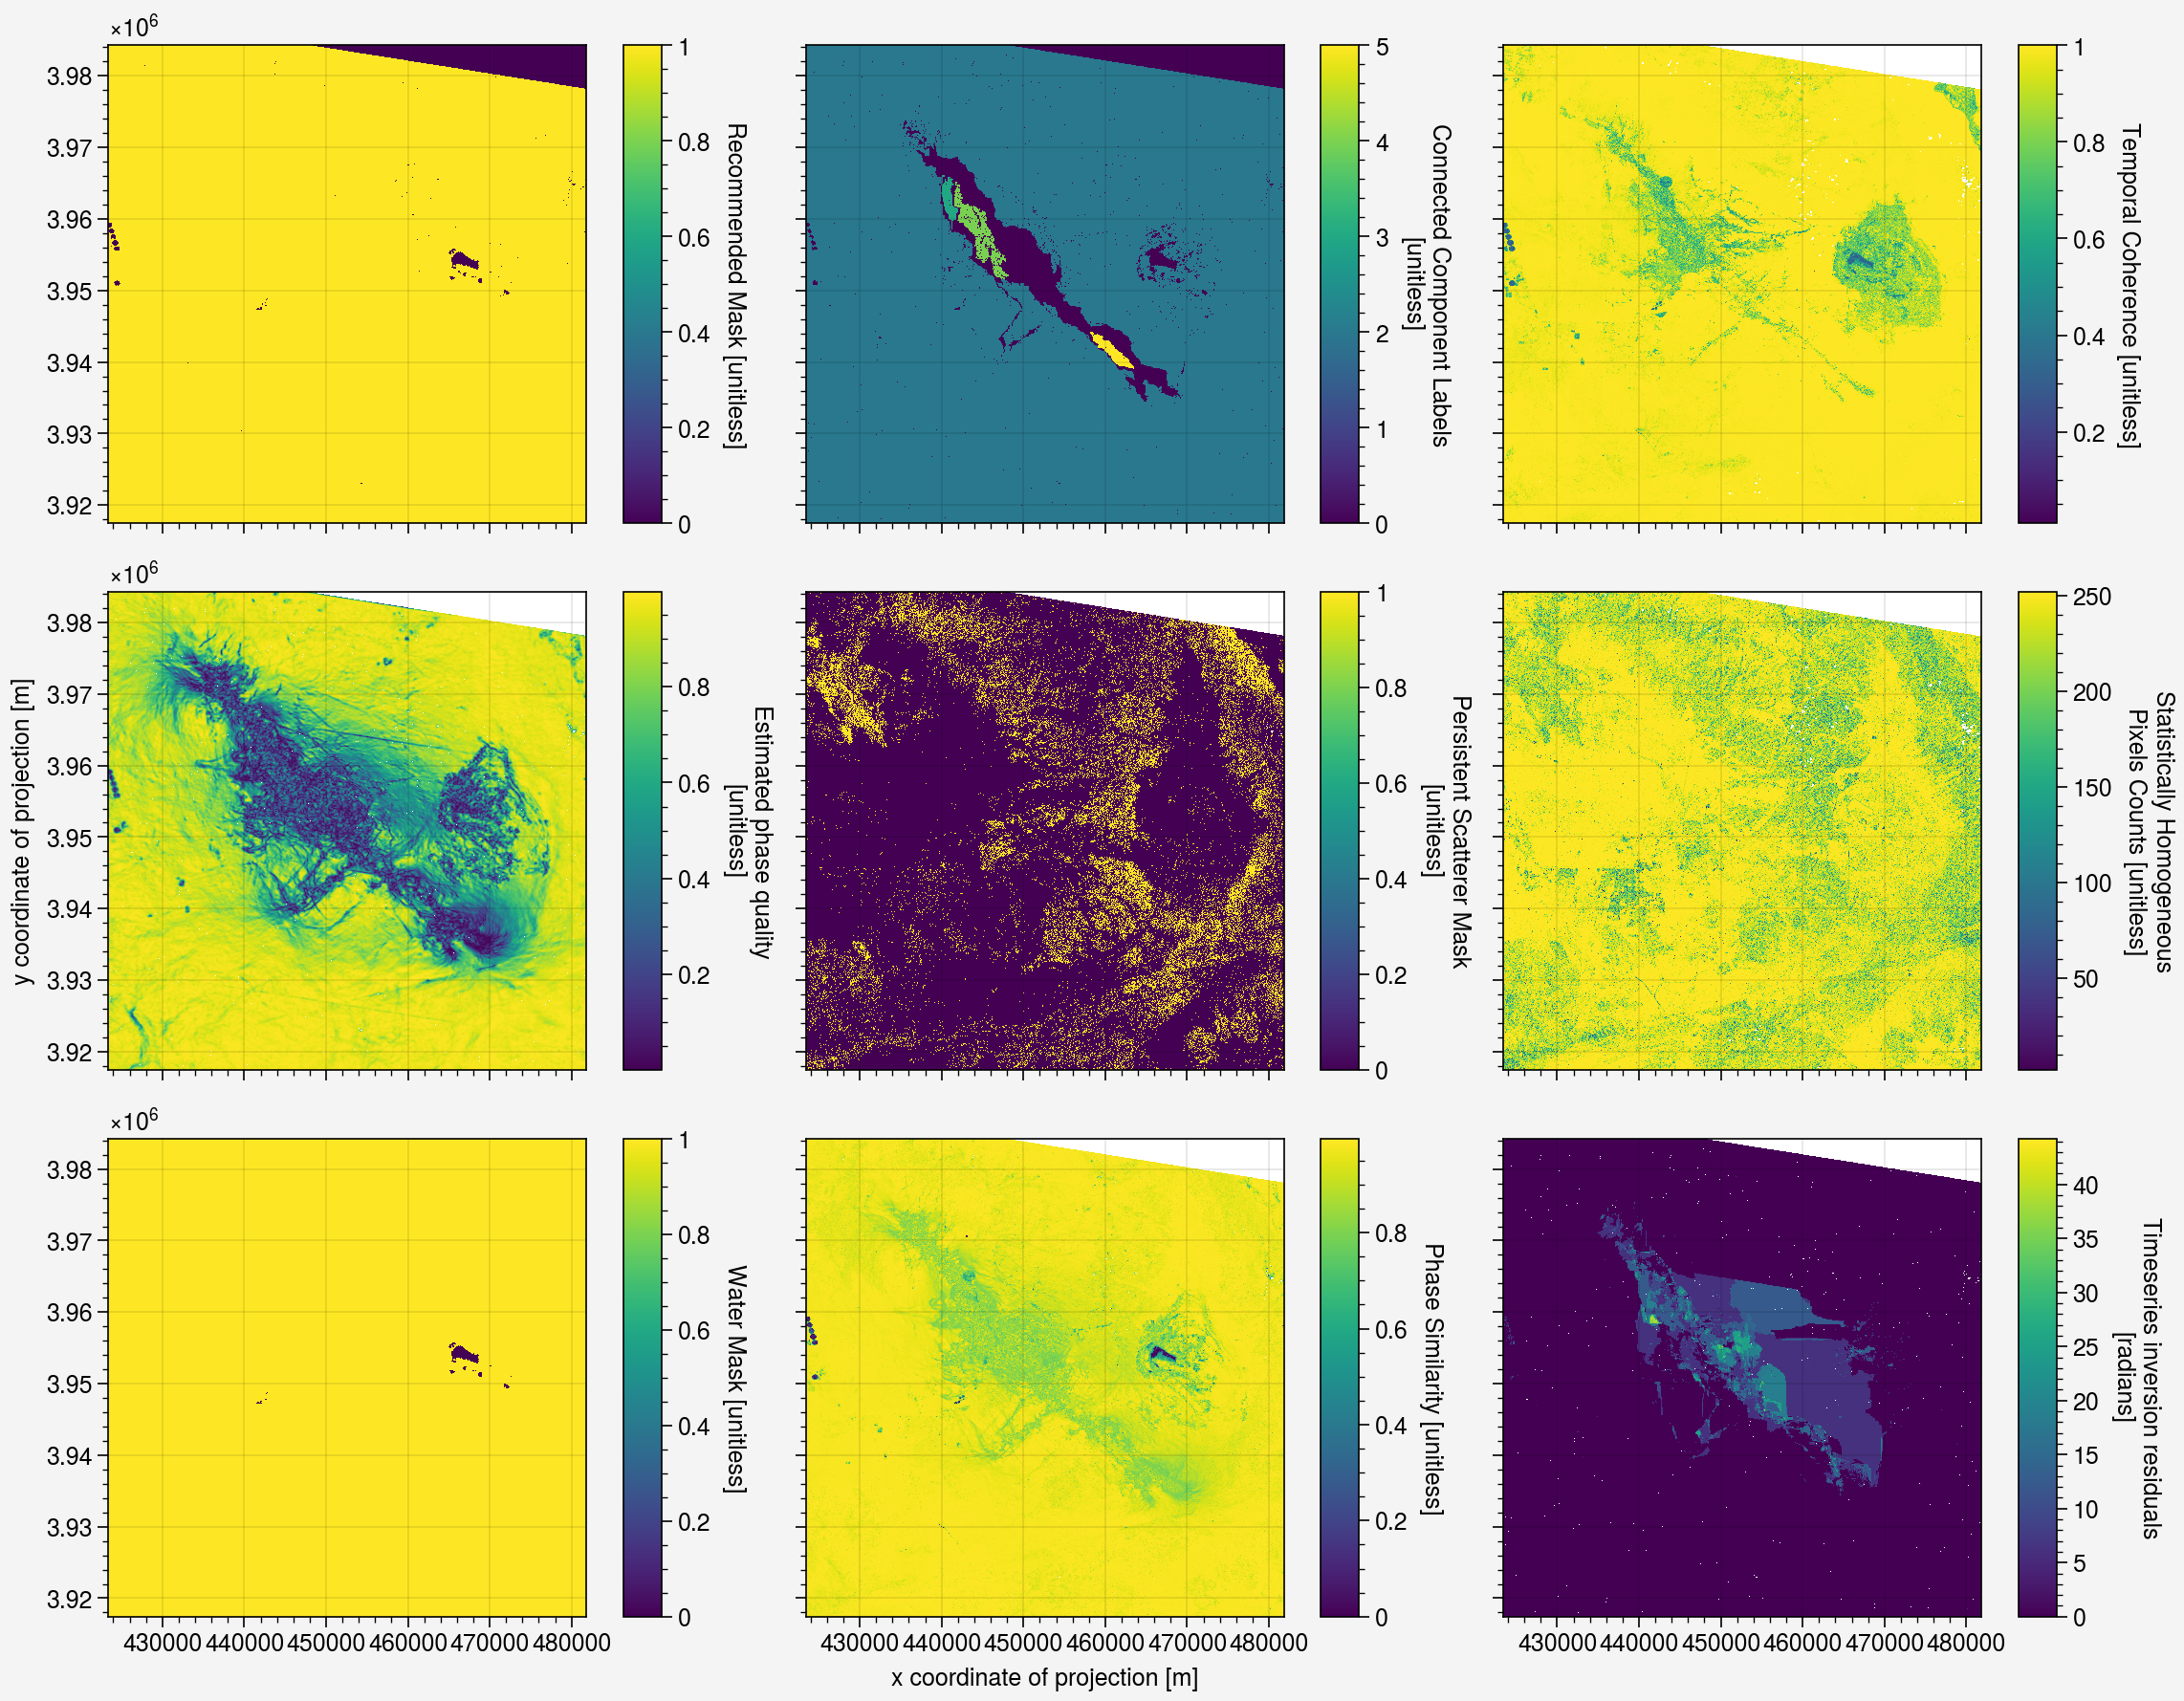

In [20]:
fig, axes = uplt.subplots(nrows=3, ncols=3)

dsets = [
    "recommended_mask",
    "connected_component_labels",
    "temporal_coherence",
    "estimated_phase_quality",
    "persistent_scatterer_mask",
    "shp_counts",
    "water_mask",
    "phase_similarity",
    "timeseries_inversion_residuals",
]
for ax, dset in zip(axes, dsets):
    da = sec_sub[dset]
    if dset == "phase_similarity":
        da = da.clip(0, 1)
    da.plot.imshow(ax=ax)

## Comparison to the "short wavelength layer"

As a point of reference for what you might see on the Portal, here is the `short_wavelength_displacement` version of the earthquake.
Note the difference in colorbar scale: the 30 kilometer filter removes all far-field displacement from the result.

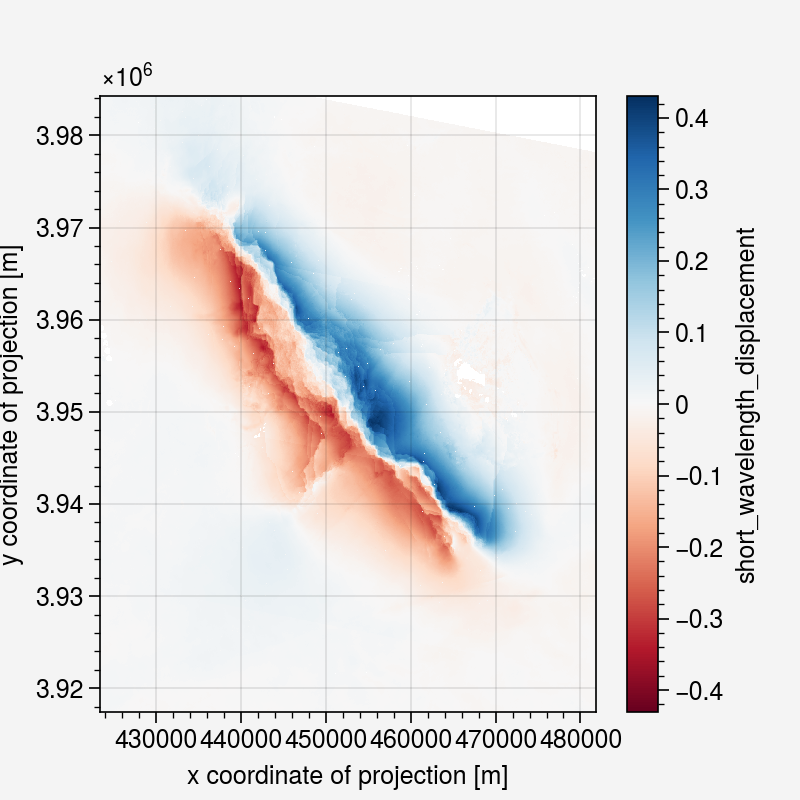

In [22]:
short_sub = (
    sec_sub.short_wavelength_displacement - ref_sub.short_wavelength_displacement
)
short_sub.plot.imshow(cmap="RdBu")

In [21]:
# Final note: You can try this locally too, since `opera-utils` is avilable via pypi!
# 1. Install UV https://docs.astral.sh/uv/#installation
# 2. Run the following to make a temporary environmentn and run the command line tool:
# (the %%bash is only needed in Jupyter, not in your terminal)
# %%bash
# TO DOWNLOAD
# uvx --from "opera-utils[disp]" opera-utils disp-s1-download
#     --output-dir opera-subset-ridgecrest
#     --frame-id 18903
#     --bbox -117.85 35.4 -117.2 36
#     --start-datetime 2019-07-03 --end-datetime 2019-07-17
#     --num-workers 2